# ASTR 598 Astrostatistics
## HW4
## Hayden Smotherman, Chris Suberlak, Winnie Wang
## To run this Notebook:

description

In [1]:
#importing all packages
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd
from scipy.stats import binned_statistic_2d as bs2d 
from scipy.stats import binned_statistic as bs1d
import seaborn as sns

#naive Bayes
from sklearn.naive_bayes import GaussianNB

#KNN
from sklearn.neighbors import KNeighborsClassifier
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#decision trees/random forest
from sklearn.tree import DecisionTreeClassifier


Steps : 
    
   * [cross-match the NSC-HLC S82 catalog](#hlc-nsc)
   * [load the SDSS DR14 QSO catalog, select S82 footprint](#add qso)
    * cross-match with NSC-HLC data to form a  training set
    * treat the rest of NSC-HLC as a test set 

# HLC-NSC crossmatch <a id='hlc-nsc'></a>

[Go to top](#toc)

NOTE:  do that only once, it takes about 10 mins.

In [2]:
test_for_catalogs = [s for s in os.listdir() if s.startswith('hlc_nsc_')]
if len(test_for_catalogs) > 0 : 
    print('There are following files that look like cross-matched HLC-NSC catalogs:')
    print(test_for_catalogs)
    print('You may go to the next step')
else : 
    print('I do not see any files that start with "hlc_nsc*" that could be \
cross-matched HLC-NSC catalogs ... ')

I do not see any files that start with "hlc_nsc*" that could be cross-matched HLC-NSC catalogs ... 


In [3]:
# Load the NSC data ... 
table_neg = Table.read('HW_2/NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('HW_2/NSC_stripe82_Dec_positive.csv')

In [4]:
# Stack the two tables vertically 
nsc = vstack([table_neg, table_pos])
print('Done')

Done


In [5]:
# Read in the HLC data : 
catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']

def ReadTable(name):
    dir_hlc = 'HW_1/'
    hlc_fits = fits.open(dir_hlc+name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

hlc = ReadTable(catalogs[0])
for catalog in catalogs[1:] : 
    print('Reading ', catalog)
    hlc_cat = ReadTable(catalog)
    hlc = vstack([hlc, hlc_cat])

print('Done reading HLC data')


Reading  HLC.RA_21_to_22.fits.gz
Reading  HLC.RA_22_to_23.fits.gz
Reading  HLC.RA_23_to_24.fits.gz
Reading  HLC.RA_00_to_01.fits.gz
Reading  HLC.RA_01_to_02.fits.gz
Reading  HLC.RA_02_to_03.fits.gz
Reading  HLC.RA_03_to_04.fits.gz
Done reading HLC data


In [6]:
# Since S82 is centered on RA=0 , stretching roughly +/- 50 degrees away
# it makes sense to change 0-360 to -180 / +180 .. 
coord= 'RA'
for col_type in  ['_MEAN','_MEAN_CLIP']:    
    c =coord+col_type
    hlc[c +'_W'] = np.where(hlc[c]>180, hlc[c]-360, hlc[c])

# Do the same for the   NSC catalog 
nsc['raW'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

Note : there is more NSC than HLC sources, so it makes sense to match HLC to NSC ( in the hope that every HLC source would have a match within more numerous NSC catalog ).



In [7]:
print('length of NSC catalog: ', len(nsc))
print('length of HLC catalog: ', len(hlc))

length of NSC catalog:  7409326
length of HLC catalog:  3700548


To make cross-matching faster, split the RA range into 10 bins of RA from -50 to +50 degrees : 

In [8]:
ra_col  = 'RA_MEAN_CLIP_W' # choose which ra,dec type to use for HLC 
dec_col = 'DEC_MEAN_CLIP'

hlc_nsc = Table()
ra = np.arange(-50,60,10)
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    mask_hlc = (ra[i]<hlc[ra_col])*(hlc[ra_col] < ra[i+1])
    mask_nsc = (ra[i]<nsc['raW'])*(nsc['raW'] < ra[i+1])
    
    hlc_sel = hlc[mask_hlc]
    nsc_sel = nsc[mask_nsc]
    
    hlc_coords = SkyCoord(ra=hlc_sel[ra_col]*u.degree, 
                          dec=hlc_sel[dec_col]*u.degree
                         )
    nsc_coords = SkyCoord(ra = nsc_sel['raW']*u.degree,  
                          dec = nsc_sel['dec']*u.degree
                         )
    
    idx, d2d, d3d = hlc_coords.match_to_catalog_sky(nsc_coords)  
    
    hlc_nsc_sel = hstack([hlc_sel, nsc_sel[idx]], table_names = ['hlc', 'nsc'])
    hlc_nsc_sel['sep_2d_arcsec'] = d2d.arcsec
    
    hlc_nsc = vstack([hlc_nsc_sel, hlc_nsc])
    
print('Finished crossmatching')    

Matching ra in range  -50 -40
Matching ra in range  -40 -30
Matching ra in range  -30 -20
Matching ra in range  -20 -10
Matching ra in range  -10 0
Matching ra in range  0 10
Matching ra in range  10 20
Matching ra in range  20 30
Matching ra in range  30 40
Matching ra in range  40 50
Finished crossmatching


In [9]:
# How many of the hlc sources had a good match ? 
mask_d2d = hlc_nsc['sep_2d_arcsec'] < 0.5
print('Of all ',len(hlc), ' HLC sources, ', len(selected), 
      ' have an NSC match within 0.5 arcsec')

NameError: name 'selected' is not defined

In [ ]:
# Make sure that there are no 'multiple' sources : those in NSC that correspond to 
# more than one HLC source. Print their number , and remove them 
matched  =  hlc_nsc['sep_2d_arcsec'] < 0.5
selected =  hlc_nsc[matched]

values, counts  = np.unique(selected['dec'], return_counts=True)
multiples = selected[np.in1d(selected['dec'], values[counts>1])]

# Remove the multiples
select= selected[~np.in1d(selected['dec'], values[counts>1])]

# add the mag, magerr cols so that all is a one table...
magcols = [f+'magHLC' for f in 'ugriz' ]
magerrcols=  [f + 'errHLC' for f in 'ugriz' ]

# Cast the compressed mag, magerr HLC columns 
# onto tables that we then stack horizontally (along columns)
mean_psfmag = Table(select['MEAN_PSFMAG_CLIP'], names=(magcols))
mean_psfmagerr = Table(select['MEAN_PSFMAG_ERR_CLIP'], names=(magerrcols))
mean_magerr = hstack([mean_psfmag, mean_psfmagerr])

# and finally add the mag-err table to the original hlc-nsc table 
select = hstack([mean_magerr, select])

# then remove these compresessed , no-longer-needed columns from
# the original table
select.remove_columns(['MEAN_PSFMAG_CLIP','MEAN_PSFMAG_ERR_CLIP',
                       'MEAN_PSFMAG','MEAN_PSFMAG_ERR'])

# rename the separation column  since we'll be cross-matching to GAIA later...
select.rename_column('sep_2d_arcsec', 'sep_2d_arcsec_HLC_NSC')

In [ ]:
# Since the above steps take quite a while, save the cross-matched table 
# with good matches ... 

# Check whether the file with cross-matched catalogs exists....
fname =  'hlc_nsc_1arcsec_'+str(len(select))+'_main'
import os 
if fname not in os.listdir() : 
    print('Saving the cross-matched catalog main columns as ', fname )

    # store in this variable all columns of combined HLC-NSC catalog 
    all_cols = np.ravel(select.colnames)

    # explicitly choose which columns to save in the main cross-matched catalog 
    select_cols = ['LC_NAME', 'IAU_NAME', 'N_GOOD_EPOCHS', 'umagHLC', 
                   'gmagHLC', 'rmagHLC', 'imagHLC', 'zmagHLC', 'uerrHLC',
                    'gerrHLC', 'rerrHLC', 'ierrHLC', 'zerrHLC',
           'N_GOOD_EPOCHS_PSF_CLIP', 
       'TIME_SPAN', 'MEAN_OBJECT_TYPE', 'REDDENING',
       'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP', 
       'RA_PM_ERR_CLIP', 'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP',
       'DEC_PM_CLIP', 'DEC_PM_ERR_CLIP',
     'T0', 'T0_CLIP','N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra', 'dec',
       'pmra', 'pmraerr', 'pmdec', 'pmdecerr', 'mjd', 'deltamjd', 'gmag',
       'grms', 'gerr', 'rmag', 'rrms', 'rerr', 'imag', 'irms', 'ierr',
       'class_star', 'fwhm', 'ebv', 'nphot', 'raW', 'sep_2d_arcsec_HLC_NSC']

    np.save(fname,select[select_cols])

    # store all other columns in the auxiliary cross-matched catalog 
    other_cols = all_cols[~np.in1d(all_cols,select_cols)]
    fname =  'hlc_nsc_1arcsec_'+str(len(select))+'_auxiliary'
    print('Saving the cross-matched catalog aux columns as ', fname )
    np.save(fname,select[list(other_cols)])

    # it can be loaded into AstroPy as  
    #test = Table(np.load(fname))

# Load HLC-NSC, add SDSS DR14 QSO <a id='add qso'></a>

[Go to top](#toc)

We load the cross-matched HLC-NSC catalog, and add the SDSS DR14 QSO

In [3]:
# Load the cross-matched HLC-NSC catalog
fname =  'hlc_nsc_1arcsec_2718343_main.npy'
hlc_nsc = Table(np.load(fname))

FileNotFoundError: [Errno 2] No such file or directory: 'HW_2/hlc_nsc_1arcsec_2718343_main.npy'

In [2]:
# Load the QSO DR14 
hdu = fits.open('DR14Q_v4_4.fits')
dr14 = Table(hdu[1].data)

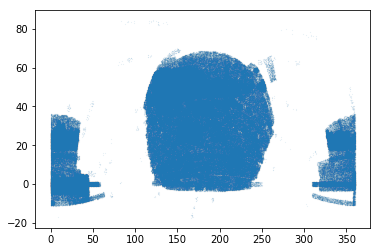

In [6]:
# This is the entire SDSS footprint ...
plt.scatter(dr14['RA'], dr14['DEC'], s=0.001)

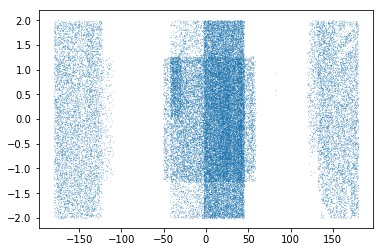

In [3]:
# Select only S82 , since we only have NSC_HLC data for S82

# re-express the ra from 0-360 to +/- 180 ..
dr14['RA_W'] = np.where(dr14['RA']>180, dr14['RA']-360, dr14['RA'])

# Plot only the selection 
m = np.abs(dr14['DEC']) < 2
plt.scatter(dr14['RA_W'][m], dr14['DEC'][m], s=0.01)


In [7]:
# add the mag, magerr cols so that all is a one table...
magcols = [f+'magSDSS' for f in 'ugriz' ]
magerrcols=  [f + 'errSDSS' for f in 'ugriz' ]

# Cast the compressed mag, magerr HLC columns 
# onto tables that we then stack horizontally (along columns)
mean_psfmag = Table(dr14['PSFMAG'], names=(magcols))
mean_psfmagerr = Table(dr14['ERR_PSFMAG'], names=(magerrcols))

mean_magerr = hstack([mean_psfmag, mean_psfmagerr])

# and finally add the mag-err table to the original hlc-nsc table 
select = hstack([mean_magerr, select])

# then remove these compresessed , no-longer-needed columns from
# the original table
select.remove_columns(['MEAN_PSFMAG_CLIP','MEAN_PSFMAG_ERR_CLIP',
                       'MEAN_PSFMAG','MEAN_PSFMAG_ERR'])



In [10]:
# add column with r-mag 
dr14_sel =dr14[['RA_W','DEC']].copy()
dr14_sel.add_column(mag['r'])
dr14_sel.rename_column('RA_W', 'ra')
dr14_sel.rename_column('DEC', 'dec')


In [12]:
m_dec = np.abs(dr14_sel['dec']) < 2
m_ra = np.abs(dr14_sel['ra']) < 50 
rmin, rmax = 17,20
m_r = (rmin < dr14_sel['r']) * (dr14_sel['r'] < rmax)
m_qso = m_dec * m_ra * m_r
print('Matching ', np.sum(m_qso), ' qso within ', rmin, '< rmag <', rmax)

Matching  7800  qso within  17 < rmag < 20


The number looks good - it's slightly higher than the combined DR9-DR12 (6455), as we would expect. 

Next : 
   * cross-match DR14 QSO in S82 to the NSC-HLC catalog 
   * save that as a training set 
   * use K-nearest neighbors to estimate density in color-color space (eg u-g vs g-r)  ( Fig. 6.4,  also Week-8-Tue lecture, chapter 6.2 in the Yellow Book ) 
   * classification with KNN - chapter 9.4 in the Yellow Book 
   * Classification: chapter 9 in the Yellow Book 
   * use Naive Bayes for classification: chapter 9.3.2 
   * use decision trees for classificaion: chapter 9.7 
   * Evaluating: chapter 9.8 on ROC Curves 